(mmm_custom_splines=)
# Custom Geo-Hierarchical MMM with Splines

This tutorial shows how to build a custom Marketing Mix Model (MMM) by combining PyMC-Marketing components with plain PyMC modeling. We follow the strategy present in the introductory notebook {ref}`mmm_components`. We use the data from the multidimensional tutorial {ref}`mmm_multidimensional_example`. To showcase the flexibility of the approach, we will build a model with:

- Hierarchical media effects across geos.
- A spline-based time-varying intercept.
- Fourier seasonality.
- Hierarchical control effects for `event_1` and `event_2`.

As we implement a PyMC model, here the flexibility is very high. We show how to use PyMC-Marketing components to model media effects and seasonality. This should reduce the code boilerplate and make the model more readable (there is no need to implement the adstock or the logistic saturation functions manually at this point).

```{tip}
*Why this custom model?*
The `MMM` class in PyMC-Marketing is very flexible. You can use it to build models with different structures. For example, you can use it to build a model with hierarchical structures and global time-varying intercepts and media multipliers. Nevertheless, in many cases teams and organizations want to have more control over the model specification. Hence, using PyMC with PyMC-Marketing allows you to implement any type of model you want.
```

## Prepare Notebook

In [21]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from patsy import dmatrix
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.fourier import YearlyFourier
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

seed: int = sum(map(ord, "mmm_custom_splines"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Load and prepare data

We use `mmm_multidimensional_example.csv` (two geos, two channels, two controls).

To keep sampling stable in this custom model, we scale media and target by geo-level maxima.

In [23]:
data_path = data_dir / "mmm_multidimensional_example.csv"
data_df = pd.read_csv(data_path, parse_dates=["date"])

date_index = np.sort(data_df["date"].unique())
geo_names = sorted(data_df["geo"].unique())
channel_columns = ["x1", "x2"]
control_columns = ["event_1", "event_2"]

channel_data: xr.DataArray = (
    data_df.set_index(["date", "geo"])[channel_columns]
    .to_xarray()
    .to_array("channel")
    .transpose("date", "geo", "channel")
)

control_data: xr.DataArray = (
    data_df.set_index(["date", "geo"])[control_columns]
    .to_xarray()
    .to_array("control")
    .transpose("date", "geo", "control")
)

target_data: xr.DataArray = (
    data_df.set_index(["date", "geo"])["y"].to_xarray().transpose("date", "geo")
)

channel_scale: xr.DataArray = channel_data.max("date")
target_scale: xr.DataArray = target_data.max("date")

channel_scaled: xr.DataArray = channel_data / channel_scale
target_scaled: xr.DataArray = target_data / target_scale

coords: dict[str, list[str]] = {
    "date": date_index,
    "geo": geo_names,
    "channel": channel_columns,
    "control": control_columns,
}

data_df.head()

,date,geo,x1,x2,event_1,event_2,y
0,2022-06-06,geo_a,5527.640078,0.000000,0,0,2647.596355
1,2022-06-06,geo_b,8849.257500,8063.918386,0,0,682.406280
2,2022-06-13,geo_a,6692.655692,0.000000,0,0,5020.823907
3,2022-06-13,geo_b,9073.817994,9354.014585,0,0,3753.104897
4,2022-06-20,geo_a,7124.016733,0.000000,0,0,6184.322132


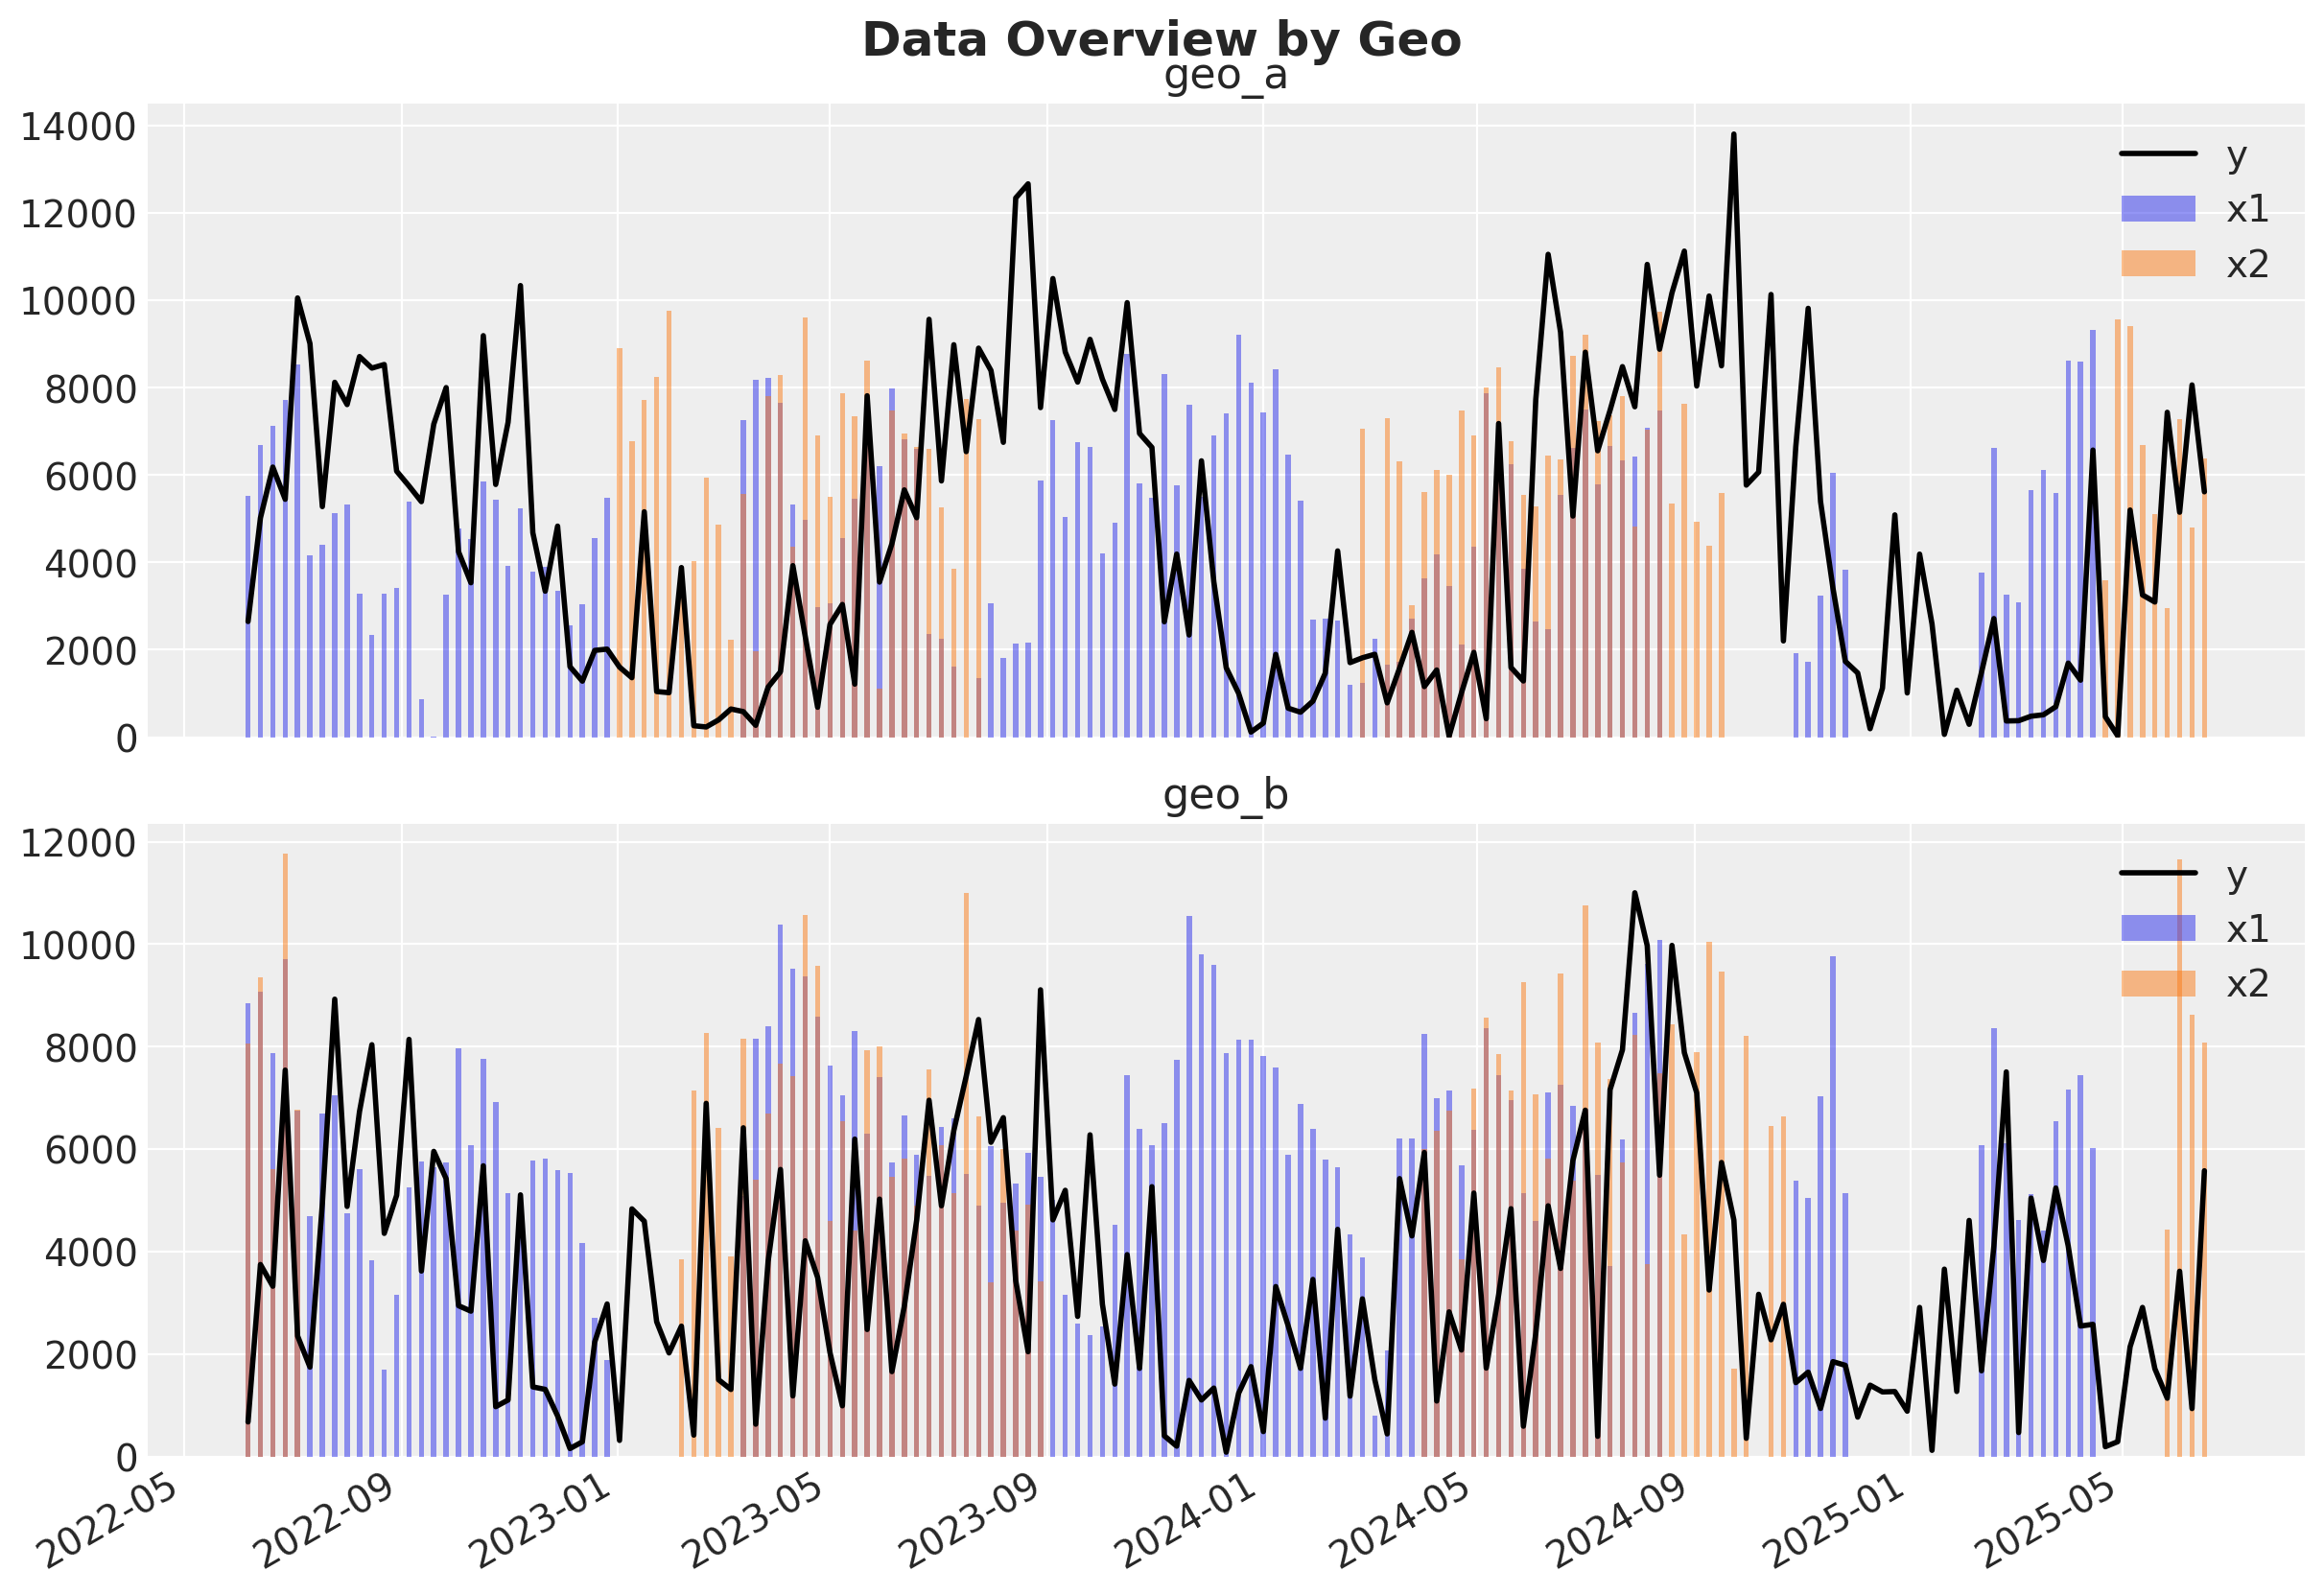

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    plot_df = data_df.query("geo == @geo")
    ax.plot(plot_df["date"], plot_df["y"], color="black", label="y", linewidth=2)
    ax.bar(plot_df["date"], plot_df["x1"], alpha=0.5, label="x1", width=3)
    ax.bar(plot_df["date"], plot_df["x2"], alpha=0.5, label="x2", width=3)
    ax.set_title(geo)
    ax.legend(loc="upper right")

fig.autofmt_xdate()
fig.suptitle("Data Overview by Geo", y=1.02, fontsize=18, fontweight="bold");

## Spline basis for a time-varying intercept

Instead of a static intercept, we let baseline demand vary smoothly over time with cubic B-splines (see the PyMC example notebook on [Splines](https://www.pymc.io/projects/examples/en/latest/howto/spline.html)).

We use fewer, more separated internal knots so the spline emphasizes longer-run baseline variation rather than short-term wiggles.

We then put a hierarchical prior on spline coefficients:

- Each geo gets its own spline weights.
- But all geos share hyperpriors, enabling partial pooling.

In [ ]:
time_idx = np.arange(len(date_index), dtype=float)

# Fewer knots increase separation and emphasize longer-run baseline movements.
n_knots = 5
knot_list = np.percentile(time_idx, np.linspace(0, 100, n_knots + 2))[1:-1]

spline_basis = np.asarray(
    dmatrix(
        "bs(t, knots=knots, degree=3, include_intercept=True) - 1",
        {"t": time_idx, "knots": knot_list},
    )
)

coords["spline"] = np.arange(spline_basis.shape[1])
spline_basis.shape

## Custom model specification

We now assemble the model from components.

Key choices:

- **Media effects**: adstock + logistic saturation from PyMC-Marketing components.
- **Seasonality**: Fourier terms with geo-specific coefficients.
- **Controls**: hierarchical coefficients for `event_1` and `event_2` over geos.
- **Baseline**: hierarchical spline intercept over geos.


```{note}
Because spline baselines and Fourier harmonics can both explain smooth temporal patterns, they can become partially confounded if left weakly constrained. To mitigate this, we keep seasonality centered with a zero-sum prior ([`ZeroSumNormal`](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.ZeroSumNormal.html)) so Fourier terms cannot absorb long-run level shifts, and we apply stronger spline regularization (`spline_mu` with `sigma=0.10` and `spline_sigma` with `sigma=0.08`) so the baseline stays smooth and captures persistent trend-level movement rather than seasonal oscillations.
```

Let's start by defining the components.

In [ ]:
adstock = GeometricAdstock(
    l_max=8,
    priors={
        "alpha": Prior("Beta", alpha=2, beta=5, dims=("geo", "channel")),
    },
)

saturation = LogisticSaturation(
    priors={
        "lam": Prior("Gamma", mu=0.5, sigma=0.25, dims="channel"),
        "beta": Prior("Gamma", mu=0.25, sigma=0.10, dims=("geo", "channel")),
    }
)

yearly_fourier = YearlyFourier(
    n_order=2,
    prefix="fourier_mode",
    variable_name="gamma_fourier",
    # Zero-sum seasonal coefficients keep yearly seasonality centered at zero.
    prior=Prior(
        "ZeroSumNormal",
        sigma=Prior("HalfNormal", sigma=0.2),
        dims=("geo", "fourier_mode"),
    ),
)

Now we are ready to build the PyMCmodel.

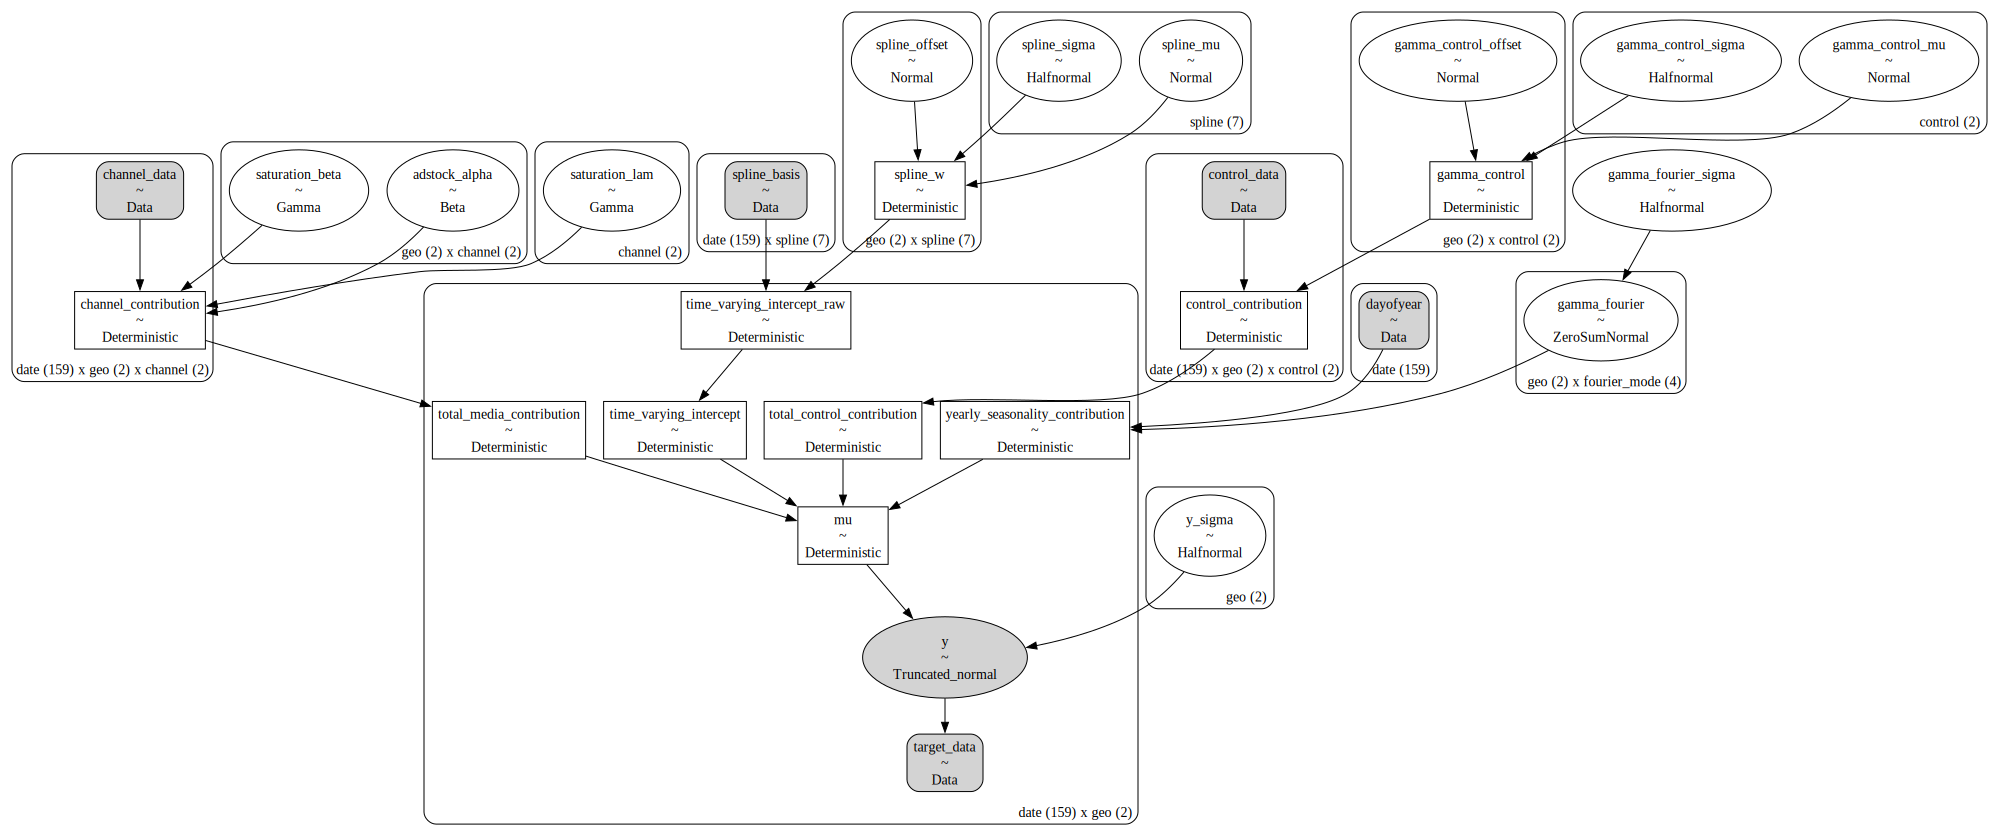

In [ ]:
with pm.Model(coords=coords) as custom_mmm:
    # Shared data containers make model updates and posterior predictive calls straightforward.
    channel_data_ = pm.Data(
        "channel_data",
        channel_scaled.transpose("date", "geo", "channel"),
        dims=("date", "geo", "channel"),
    )
    control_data_ = pm.Data(
        "control_data",
        control_data.transpose("date", "geo", "control"),
        dims=("date", "geo", "control"),
    )
    target_data_ = pm.Data(
        "target_data", target_scaled.transpose("date", "geo"), dims=("date", "geo")
    )
    dayofyear_ = pm.Data(
        "dayofyear", pd.DatetimeIndex(date_index).dayofyear.values, dims="date"
    )
    spline_basis_ = pm.Data("spline_basis", spline_basis, dims=("date", "spline"))

    # Spline baseline: one smooth coefficient vector per geo, with shared hyperpriors
    # so geos can borrow strength (partial pooling) rather than fit independently.
    spline_mu = pm.Normal("spline_mu", mu=0, sigma=0.10, dims="spline")
    spline_sigma = pm.HalfNormal("spline_sigma", sigma=0.08, dims="spline")
    spline_offset = pm.Normal("spline_offset", mu=0, sigma=1, dims=("geo", "spline"))
    spline_w = pm.Deterministic(
        "spline_w",
        spline_mu + spline_offset * spline_sigma,
        dims=("geo", "spline"),
    )

    # Build an unconstrained smooth baseline first, then map it to positive values.
    # This follows the same positivity idea used by SoftPlusHSGP in PyMC-Marketing.
    time_varying_intercept_raw = pm.Deterministic(
        "time_varying_intercept_raw",
        pm.math.dot(spline_basis_, spline_w.T),
        dims=("date", "geo"),
    )
    time_varying_intercept = pm.Deterministic(
        "time_varying_intercept",
        pt.softplus(time_varying_intercept_raw),
        dims=("date", "geo"),
    )

    # Media block: carryover (adstock) first, then diminishing returns (saturation).
    # We keep per-geo, per-channel effects by passing dims=("geo", "channel").
    adstocked_media = adstock.apply(channel_data_, dims=("geo", "channel"))
    channel_contribution = pm.Deterministic(
        "channel_contribution",
        saturation.apply(adstocked_media, dims=("geo", "channel")),
        dims=("date", "geo", "channel"),
    )
    total_media_contribution = pm.Deterministic(
        "total_media_contribution",
        channel_contribution.sum(axis=-1),
        dims=("date", "geo"),
    )

    # Control block: event effects are hierarchical over geos.
    # Each event gets a global mean + event-specific dispersion, then geo-level offsets.
    gamma_control_mu = pm.Normal("gamma_control_mu", mu=0, sigma=0.5, dims="control")
    gamma_control_sigma = pm.HalfNormal(
        "gamma_control_sigma", sigma=0.5, dims="control"
    )
    gamma_control_offset = pm.Normal(
        "gamma_control_offset", mu=0, sigma=1, dims=("geo", "control")
    )
    gamma_control = pm.Deterministic(
        "gamma_control",
        gamma_control_mu + gamma_control_offset * gamma_control_sigma,
        dims=("geo", "control"),
    )

    control_contribution = pm.Deterministic(
        "control_contribution",
        control_data_ * gamma_control,
        dims=("date", "geo", "control"),
    )
    total_control_contribution = pm.Deterministic(
        "total_control_contribution",
        control_contribution.sum(axis=-1),
        dims=("date", "geo"),
    )

    # Seasonal block: Fourier harmonics capture recurring yearly patterns by geo.
    yearly_seasonality_contribution = pm.Deterministic(
        "yearly_seasonality_contribution",
        yearly_fourier.apply(dayofyear_),
        dims=("date", "geo"),
    )

    # Final additive predictor in scaled space.
    # No extra intercept is needed: the spline baseline already plays that role.
    mu = pm.Deterministic(
        "mu",
        time_varying_intercept
        + total_media_contribution
        + total_control_contribution
        + yearly_seasonality_contribution,
        dims=("date", "geo"),
    )

    # Geo-specific residual noise keeps uncertainty flexible across markets.
    y_sigma = pm.HalfNormal("y_sigma", sigma=0.2, dims="geo")

    # Likelihood on scaled target; lower=0 keeps predictions non-negative.
    pm.TruncatedNormal(
        "y",
        mu=mu,
        sigma=y_sigma,
        lower=0,
        observed=target_data_,
        dims=("date", "geo"),
    )

pm.model_to_graphviz(custom_mmm)

## Prior predictive check

A quick prior predictive check helps verify that our model can generate plausible trajectories before fitting.

Sampling: [adstock_alpha, gamma_control_mu, gamma_control_offset, gamma_control_sigma, gamma_fourier, gamma_fourier_sigma, saturation_beta, saturation_lam, spline_mu, spline_offset, spline_sigma, y, y_sigma]


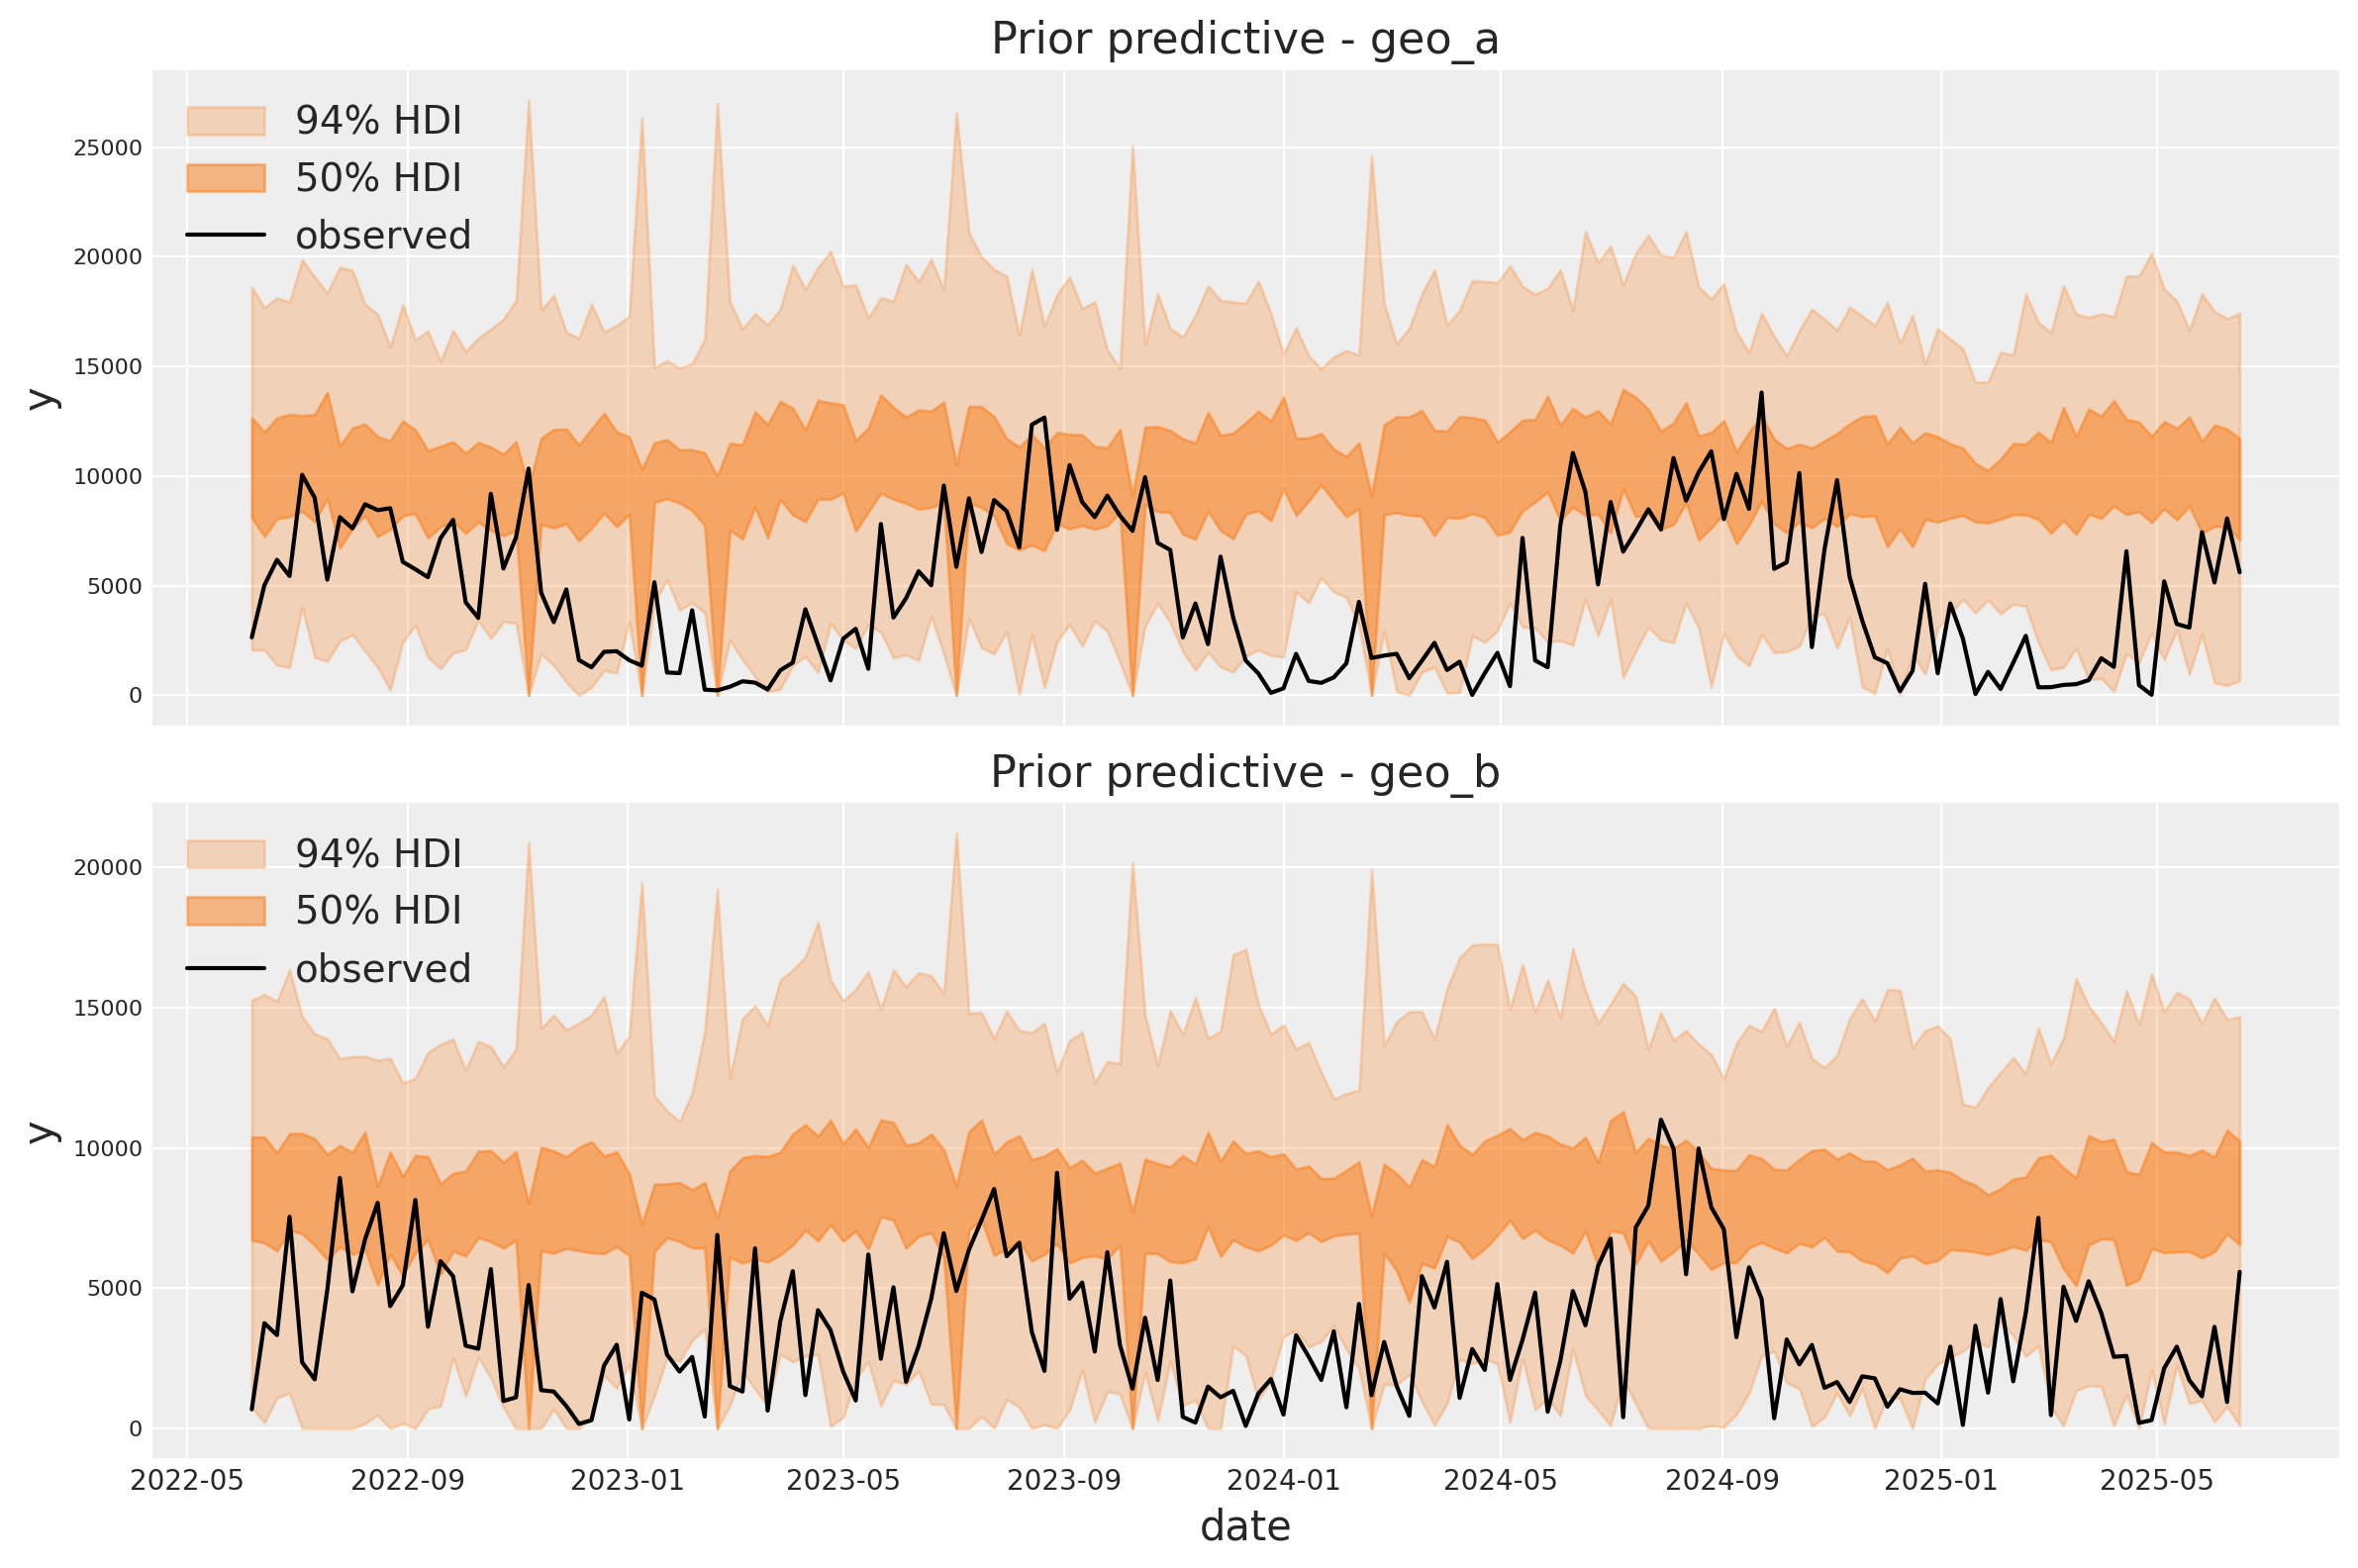

In [13]:
with custom_mmm:
    prior = pm.sample_prior_predictive(samples=300, random_seed=rng)

prior_ppc_original = prior.prior_predictive["y"] * target_scale

fig, axes = plt.subplots(nrows=len(geo_names), figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    for i, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            x=date_index,
            y=prior_ppc_original.sel(geo=geo),
            hdi_prob=hdi_prob,
            smooth=False,
            fill_kwargs={"alpha": 0.25 + 0.25 * i, "label": f"{hdi_prob:.0%} HDI"},
            ax=ax,
        )
    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
        label="observed",
    )
    ax.set_title(f"Prior predictive - {geo}")
    ax.legend(loc="upper left")

plt.tight_layout()

## Fit and posterior predictive

We keep the fitting section compact and focus on whether the specification behaves well:

- no divergences,
- stable chains,
- reasonable posterior predictive fit.

In [7]:
with custom_mmm:
    idata = pm.sample(
        chains=4,
        tune=1_000,
        draws=1_000,
        nuts_sampler="nutpie",
        target_accept=0.95,
        random_seed=rng,
    )
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

idata.sample_stats["diverging"].sum(("chain", "draw"))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.19,31
,2000,0,0.18,31
,2000,0,0.18,31
,2000,0,0.17,31


Sampling: [y]


Output()

<xarray.DataArray 'diverging' ()> Size: 8B
array(0)

## Baseline from splines: `time_varying_intercept`

The spline term is our smooth baseline component. It captures persistent temporal variation that is not directly explained by media, controls, or seasonal Fourier terms.

Below we plot its posterior uncertainty by geo on the original target scale.

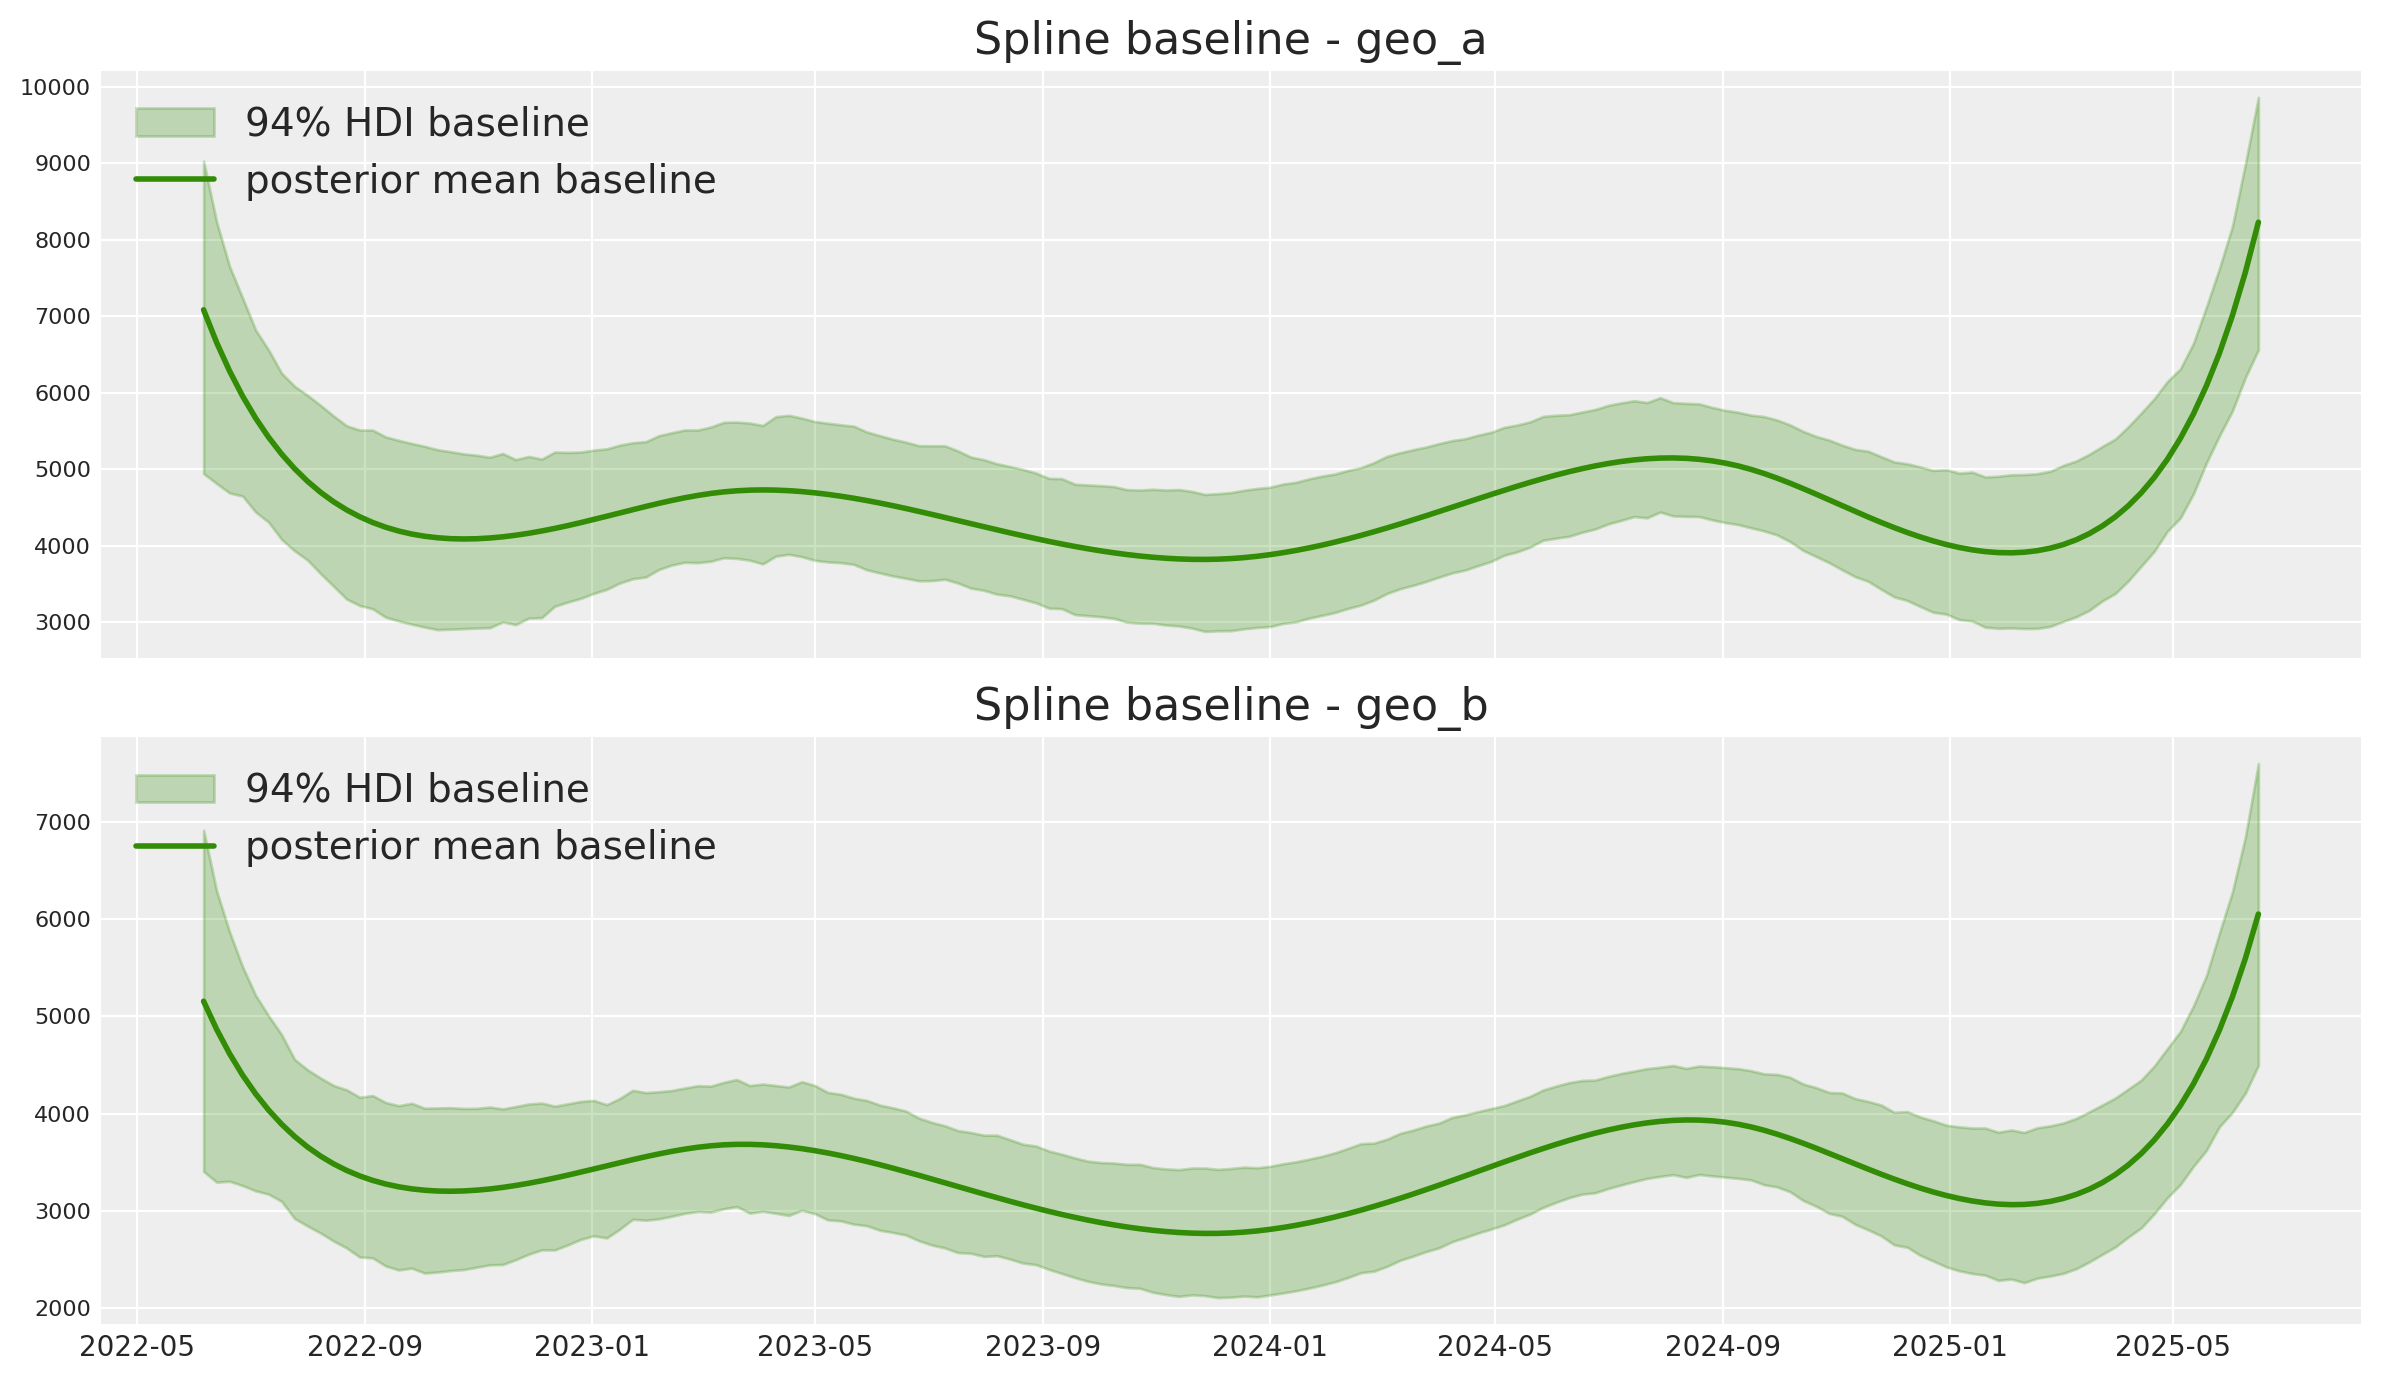

In [8]:
baseline_original = idata.posterior["time_varying_intercept"] * target_scale

fig, axes = plt.subplots(nrows=len(geo_names), figsize=(12, 7), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    baseline_geo = baseline_original.sel(geo=geo)
    az.plot_hdi(
        x=date_index,
        y=baseline_geo,
        hdi_prob=0.94,
        smooth=False,
        color="C2",
        fill_kwargs={"alpha": 0.25, "label": "94% HDI baseline"},
        ax=ax,
    )
    ax.plot(
        date_index,
        baseline_geo.mean(("chain", "draw")),
        color="C2",
        linewidth=2,
        label="posterior mean baseline",
    )
    ax.set_title(f"Spline baseline - {geo}")
    ax.legend(loc="upper left")

plt.tight_layout()

In [9]:
summary = az.summary(
    idata,
    var_names=[
        "gamma_control_mu",
        "gamma_control_sigma",
        "gamma_control",
        "spline_sigma",
        "y_sigma",
        "saturation_lam",
    ],
)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_control_mu[event_1],0.081,0.226,-0.344,0.536,0.006,0.005,1686.0,1997.0,1.00
gamma_control_mu[event_2],-0.119,0.206,-0.535,0.280,0.004,0.005,2474.0,1835.0,1.00
gamma_control_sigma[event_1],0.317,0.228,0.000,0.727,0.005,0.004,1197.0,1082.0,1.01
gamma_control_sigma[event_2],0.243,0.218,0.000,0.653,0.004,0.004,1777.0,1611.0,1.00
"gamma_control[geo_a, event_1]",-0.039,0.157,-0.318,0.266,0.003,0.002,3094.0,3154.0,1.00
"gamma_control[geo_a, event_2]",-0.095,0.141,-0.362,0.163,0.002,0.002,4673.0,3744.0,1.00
"gamma_control[geo_b, event_1]",0.218,0.121,-0.024,0.437,0.002,0.002,3097.0,3045.0,1.00
"gamma_control[geo_b, event_2]",-0.188,0.139,-0.438,0.070,0.002,0.002,4721.0,3456.0,1.00
spline_sigma[0],0.169,0.082,0.002,0.293,0.002,0.001,1475.0,1279.0,1.00
spline_sigma[1],0.376,0.064,0.252,0.491,0.001,0.001,2490.0,2340.0,1.00


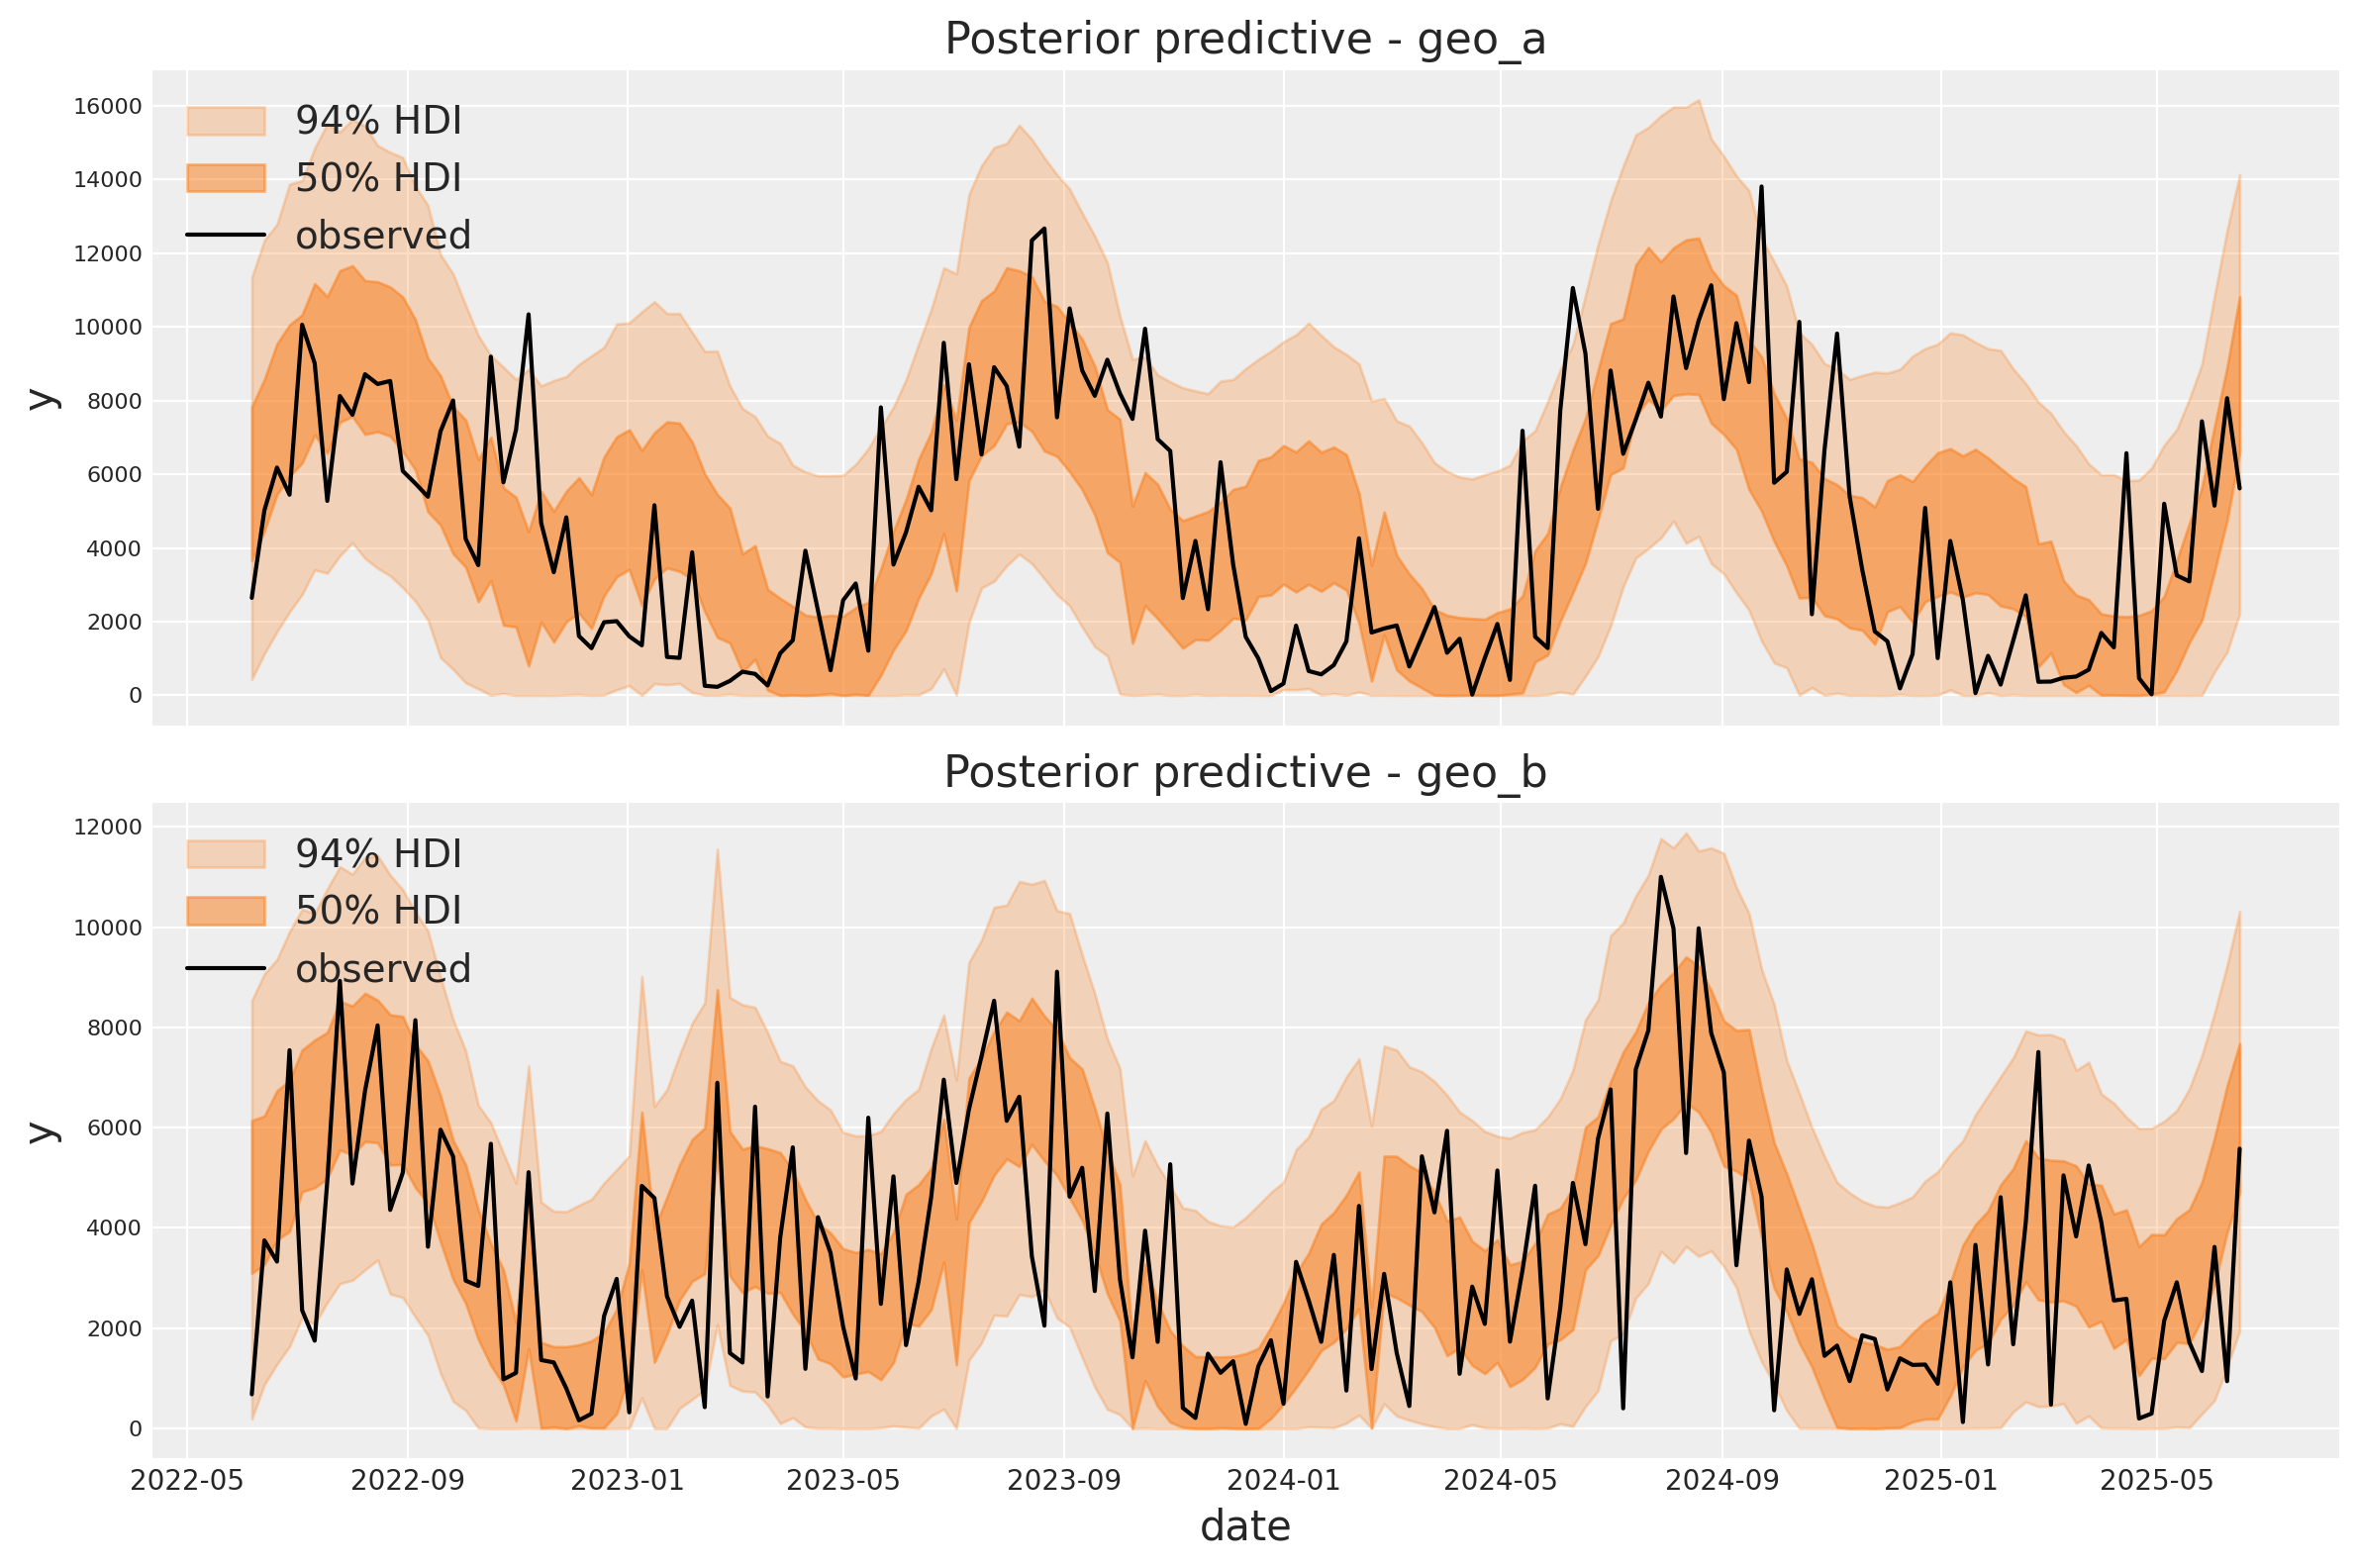

In [10]:
posterior_ppc_original = idata.posterior_predictive["y"] * target_scale

fig, axes = plt.subplots(nrows=len(geo_names), figsize=(12, 8), sharex=True)

for ax, geo in zip(axes, geo_names, strict=True):
    az.plot_hdi(
        x=date_index,
        y=posterior_ppc_original.sel(geo=geo),
        hdi_prob=0.94,
        smooth=False,
        fill_kwargs={"alpha": 0.25, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=date_index,
        y=posterior_ppc_original.sel(geo=geo),
        hdi_prob=0.5,
        smooth=False,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
        label="observed",
    )
    ax.set_title(f"Posterior predictive - {geo}")
    ax.legend(loc="upper left")

plt.tight_layout()

## Model Components in Original Scale

To mirror the multidimensional MMM tutorial workflow, we now extract and visualize the posterior contribution of each component:

- channel contributions,
- spline baseline (`time_varying_intercept`),
- Fourier seasonality,
- and control effects.

This decomposition helps users inspect how each modeled signal contributes to the observed target trajectory.

Text(0.5, 0.98, 'Posterior Predictive - Component Contributions')

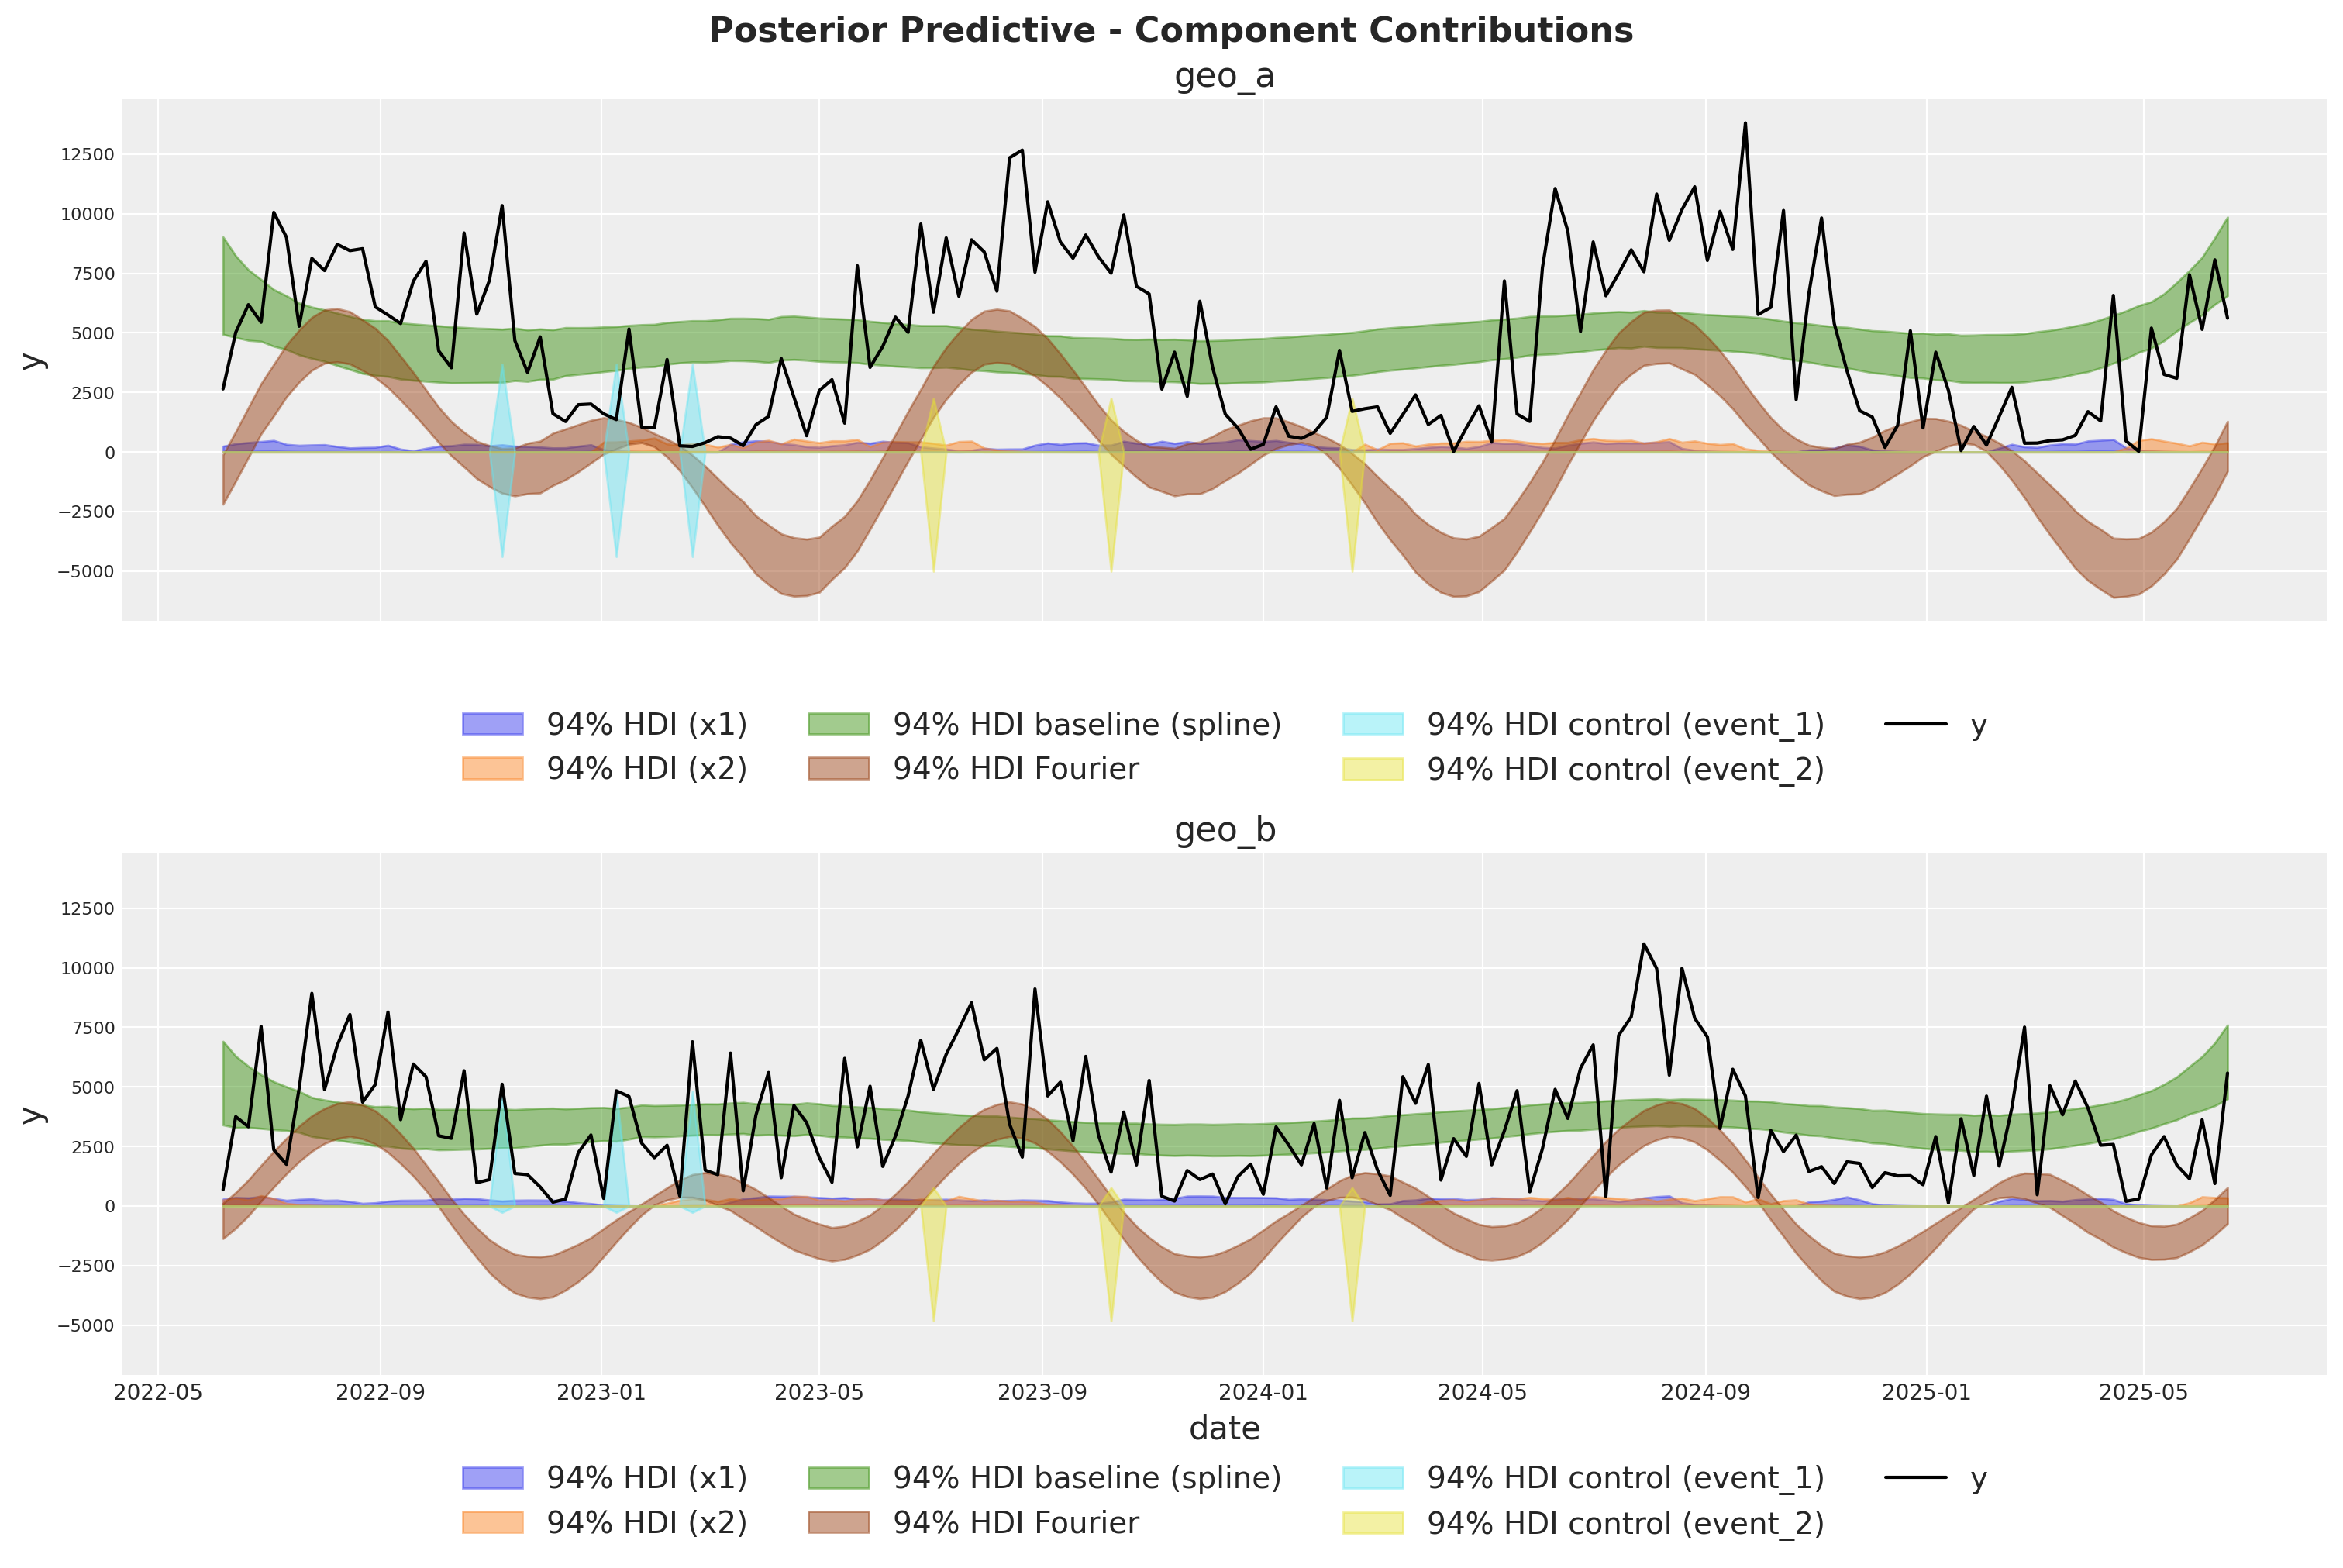

In [11]:
channel_original = idata.posterior["channel_contribution"] * target_scale
control_original = idata.posterior["control_contribution"] * target_scale
fourier_original = idata.posterior["yearly_seasonality_contribution"] * target_scale
baseline_original = idata.posterior["time_varying_intercept"] * target_scale

fig, axes = plt.subplots(
    nrows=len(geo_names),
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(geo_names):
    ax = axes[i]

    for j, channel in enumerate(channel_columns):
        az.plot_hdi(
            x=date_index,
            y=channel_original.sel(geo=geo, channel=channel),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.45, "label": f"94% HDI ({channel})"},
            ax=ax,
        )

    az.plot_hdi(
        x=date_index,
        y=baseline_original.sel(geo=geo),
        color="C2",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.45, "label": "94% HDI baseline (spline)"},
        ax=ax,
    )

    az.plot_hdi(
        x=date_index,
        y=fourier_original.sel(geo=geo),
        color="C4",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.45, "label": "94% HDI Fourier"},
        ax=ax,
    )

    for k, control in enumerate(control_columns):
        az.plot_hdi(
            x=date_index,
            y=control_original.sel(geo=geo, control=control),
            color=f"C{5 + k}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.45, "label": f"94% HDI control ({control})"},
            ax=ax,
        )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        label="y",
        ax=ax,
    )

    ax.set(title=f"{geo}", ylabel="y")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=4)

axes[-1].set_xlabel("date")
fig.suptitle(
    "Posterior Predictive - Component Contributions", fontsize=16, fontweight="bold"
)

## What this model demonstrates

This custom specification highlights how to combine PyMC-Marketing components and custom PyMC structure:

- **Hierarchical geo structure** for media and controls,
- **Spline baseline** for smooth long-run variation,
- **Fourier seasonality** for periodic behavior,
- and a clean additive decomposition in a single probabilistic model.

From here, you can iterate on priors, pooling assumptions, and the likelihood for your specific use case.